# Sampling Methods and MCMC
George Ho 12/7/17

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from scipy.stats import norm, multivariate_normal
from random import shuffle

## Rejection Sampling a Gaussian Mixture

In [2]:
def gmm(x):
    ''' Gaussian mixture model to sample from '''
    return 0.5*norm.pdf(x, -3, 2) \
           + 0.2*norm.pdf(x, 0, 1) \
           + 0.3*norm.pdf(x, 5, 3)
        
        
def proposal(x):
    ''' Gaussian proposal distribution '''
    return 2*norm.pdf(x, 0, 5)

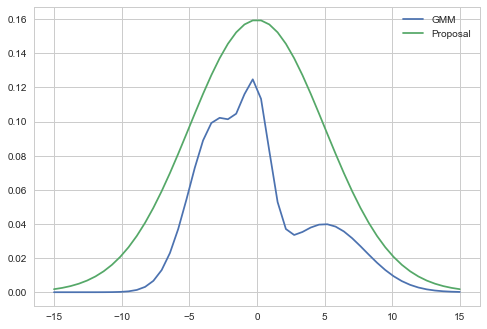

In [3]:
# Make sure our proposal distribution dominates our GMM
x = np.linspace(-15, 15)
y = gmm(x)
p = proposal(x)
plt.plot(x, y, label='GMM')
plt.plot(x, p, label='Proposal')
plt.legend()
plt.show()

In [4]:
# Rejection sampling

samples = []
for _ in range(10000):
    z = np.random.normal(0, 5)
    u = np.random.uniform(0, proposal(z))
    if u < gmm(z):
        samples.append(z)

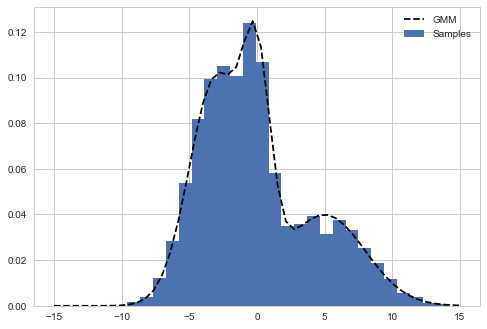

In [5]:
# Plot!

plt.hist(samples, bins=25, normed=True, label='Samples')
plt.plot(x, y, 'k--', label='GMM')
plt.legend()
plt.show()

## MCMC for Bayesian Linear Regression

In [6]:
num_obs = 25    # Number of observations

# f(x) = (a_0) + (a_1)x + noise
a_0 = 0.3       # Intercept (ground truth)
a_1 = 0.5       # Slope (ground truth)
beta = 25       # Precision (known)

In [7]:
# Generate observations
x = np.random.uniform(-1, 1, num_obs)
shuffle(x)
t = a_0 + a_1*x + np.random.normal(0, np.sqrt(1/beta), num_obs)

In [8]:
def log_p(w):
    means = w.T @ np.vstack([np.ones_like(x), x])
    log_likelihood = np.log(norm(loc=means, scale=np.sqrt(1/beta)).pdf(t)).sum()
    
    # Change this line to whatever you want!
    # It just needs to be the pdf of a bivariate distribution, evaluated at w
    prior = multivariate_normal(mean=np.zeros(2), cov=np.identity(2)).pdf(w)
    log_prior = np.log(prior)
    
    return log_likelihood + log_prior

In [9]:
# Initial z_0
z = np.zeros([1, 2])

for _ in range(10000):
    # Draw from proposal distribution, centered at previous z
    z_star = multivariate_normal(mean=z[-1, :], cov=0.2*np.identity(2)).rvs()

    # Acceptance probability. exp and log for numerical accuracy.
    A = np.exp(np.min([0, log_p(z_star) - log_p(z[-1, :])]))

    # Accept or reject the proposed sample
    if np.random.uniform() < A:
        z = np.vstack([z, z_star])
    else:
        z = np.vstack([z, z[-1, :]])

# Toss burn-in samples
z = z[500:, :]

In [10]:
print('Estimate for w: {}'.format(z.mean(axis=0)))

Estimate for w: [ 0.36329394  0.45727721]


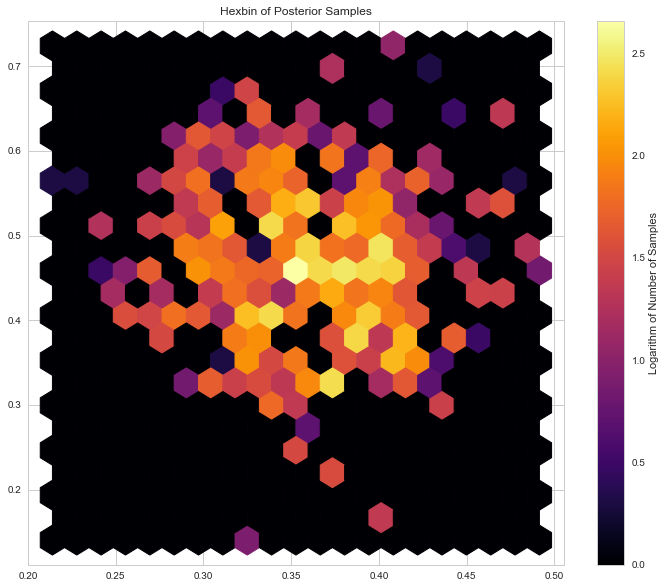

In [11]:
# Color gradient on log scale to make them more distinct
fig, ax = plt.subplots(figsize=[12, 10])
hb = ax.hexbin(z[:, 0], z[:, 1], gridsize=20, bins='log', cmap='inferno')
ax.set_title('Hexbin of Posterior Samples')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Logarithm of Number of Samples')
plt.show()